In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/levid-custom/levid_custom/val/label/val_8.png
/kaggle/input/levid-custom/levid_custom/val/label/val_6.png
/kaggle/input/levid-custom/levid_custom/val/label/val_31.png
/kaggle/input/levid-custom/levid_custom/val/label/val_54.png
/kaggle/input/levid-custom/levid_custom/val/label/val_22.png
/kaggle/input/levid-custom/levid_custom/val/label/val_3.png
/kaggle/input/levid-custom/levid_custom/val/label/val_45.png
/kaggle/input/levid-custom/levid_custom/val/label/val_37.png
/kaggle/input/levid-custom/levid_custom/val/label/val_19.png
/kaggle/input/levid-custom/levid_custom/val/label/val_20.png
/kaggle/input/levid-custom/levid_custom/val/label/val_32.png
/kaggle/input/levid-custom/levid_custom/val/label/val_53.png
/kaggle/input/levid-custom/levid_custom/val/label/val_33.png
/kaggle/input/levid-custom/levid_custom/val/label/val_43.png
/kaggle/input/levid-custom/levid_custom/val/label/val_21.png
/kaggle/input/levid-custom/levid_custom/val/label/val_25.png
/kaggle/input/levid-custom/

In [3]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images_dir_b = os.path.join(data_dir, 'B')  # Prechange
        self.images_dir_a = os.path.join(data_dir, 'A')  # Postchange
        self.masks_dir = os.path.join(data_dir, 'label')
        
        self.transform = transform

        # Ensure consistent order of files
        self.images_b = sorted(f for f in os.listdir(self.images_dir_b) if f.endswith(('.jpg', '.png', '.jpeg')))
        self.images_a = sorted(f for f in os.listdir(self.images_dir_a) if f.endswith(('.jpg', '.png', '.jpeg')))
        self.masks = sorted(f for f in os.listdir(self.masks_dir) if f.endswith(('.jpg', '.png', '.jpeg')))

    def __len__(self):
        return len(self.images_b)

    def __getitem__(self, idx):
        img_path_b = os.path.join(self.images_dir_b, self.images_b[idx])
        img_path_a = os.path.join(self.images_dir_a, self.images_a[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load images
        image_b = cv2.imread(img_path_b, cv2.IMREAD_COLOR)  # BGR
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_b = image_b.astype(np.float32) / 255.0  # Normalize to [0, 1]

        image_a = cv2.imread(img_path_a, cv2.IMREAD_COLOR)  # BGR
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_a = image_a.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Apply transformations consistently
        if self.transform:
            transformed = self.transform(image=image_b, image_a=image_a, mask=mask)
            image_b = transformed['image']  # Pre-change
            image_a = transformed['image_a']  # Post-change
            mask = transformed['mask']  # Mask

        # Convert mask to tensor and add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dim

        return image_b, image_a, mask

# Albumentations transformations
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2(),
], additional_targets={'image_a': 'image'})

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
], additional_targets={'image_a': 'image'})

# Dataset
train_dataset = CustomDataset(data_dir='/kaggle/input/levid-custom/levid_custom/train', transform=train_transform)
val_dataset = CustomDataset(data_dir='/kaggle/input/levid-custom/levid_custom/val', transform=val_transform)
test_dataset = CustomDataset(data_dir='/kaggle/input/levid-custom/levid_custom/test', transform=val_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

Number of training samples: 445
Number of validation samples: 64
Number of test samples: 128


In [5]:
image1, image2, mask = train_dataset[0]

print(f'Image 1 shape: {image1.shape}')
print(f'Image 2 shape: {image2.shape}')
print(f'Mask shape: {mask.shape}')

print(torch.unique(mask))  # Check mask values
print(torch.unique(image1))  # Check image values
print(torch.unique(image2))  # Check image values

print(torch.unique(mask).numel()) # Check number of unique mask values

Image 1 shape: torch.Size([3, 256, 256])
Image 2 shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])
tensor([0., 1.])
tensor([0.0049, 0.0059, 0.0069,  ..., 0.9608, 0.9853, 0.9882])
tensor([0.0000e+00, 9.8039e-04, 1.9608e-03,  ..., 9.9804e-01, 9.9902e-01,
        1.0000e+00])
2


<ipython-input-3-1ee24388bb94>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dim


<ipython-input-3-1ee24388bb94>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dim


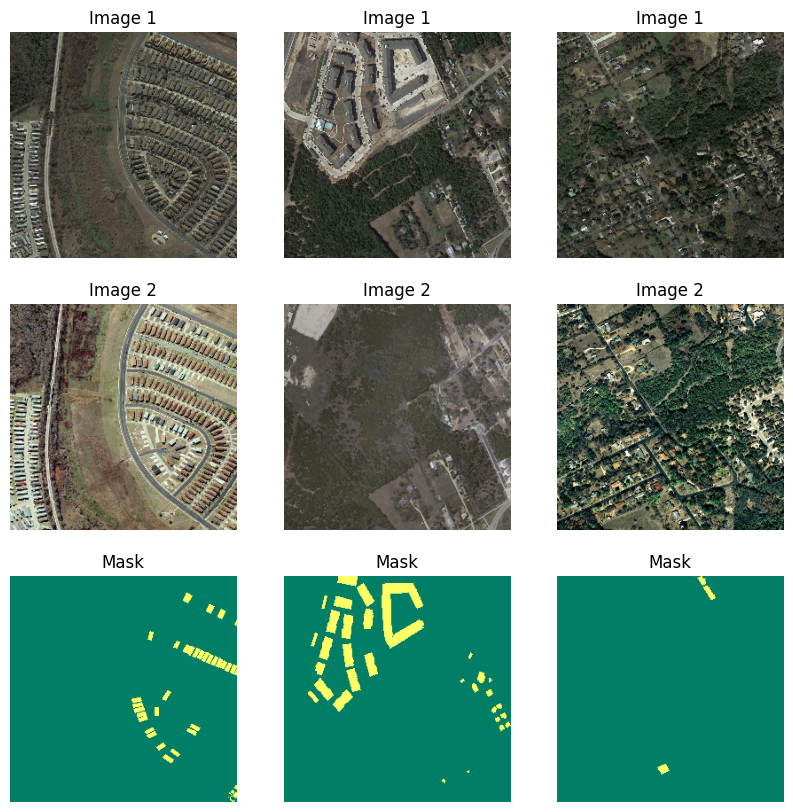

In [6]:
import matplotlib.pyplot as plt
import random

# Set up the plot size and axis
plt.figure(figsize=(10, 10))

# Randomly select 3 indices from the dataset
random_indices = random.sample(range(len(train_dataset)), 3)

for i, idx in enumerate(random_indices):
    # Get the images and mask from the dataset
    image1, image2, mask = train_dataset[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image1.permute(1, 2, 0), cmap='summer')
    plt.axis('off')
    plt.title('Image 1')

    plt.subplot(3, 3, i + 4)
    plt.imshow(image2.permute(1, 2, 0), cmap='summer')
    plt.axis('off')
    plt.title('Image 2')

    plt.subplot(3, 3, i + 7)
    plt.imshow(mask.permute(1, 2, 0), cmap='summer')
    plt.axis('off')
    plt.title('Mask')

plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Define the ConvBlock class
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):  # Correctly define the forward method
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Define the EncoderBlock class
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        p = self.maxpool(x)  # Save the output for skip connection
        return x, p  # Return both the output and the skip connection output

# Decoder block: Consist of upsample followed by two CNN
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Align the spatial dimensions of x and skip
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# Main combined Encoder Siamese U-Net architecture
class SiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseUNet, self).__init__()

        # Encoder blocks for image 1
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)

        # Encoder blocks for image 2
        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(1024, 1024)  # Updated to accept 1024 input channels

        # Decoder blocks (Shared between image 1 and image 2)
        self.decoder4 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)

        # Final convolutional to output the mask
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Encoder part for image 1
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)

        # Encoder part for image 2
        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # Bottleneck
        bottleneck = self.bottleneck(torch.cat([e4a, e4b], dim=1))  # Concatenate along channel dimension

        # Decoder part
        d4 = self.decoder4(bottleneck, e4a)
        d3 = self.decoder3(d4, e3a)
        d2 = self.decoder2(d3, e2a)
        d1 = self.decoder1(d2, e1a)

        # Output layer
        out = self.sigmoid(self.final_conv(d1))
        return out

# Test the SiameseUNet model
x1 = torch.randn(1, 3, 256, 256)  # Random input for image 1
x2 = torch.randn(1, 3, 256, 256)  # Random input for image 2

# Initiate the siamese U-net model
SiameseUNet_model = SiameseUNet(in_channels=3, out_channels=1)

# Get the Output
output = SiameseUNet_model(x1, x2)

print(output.shape)

torch.Size([1, 1, 256, 256])


In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from PIL import Image

# Example custom dataset (you should adjust it for LEVIR-CD dataset)
class LEVIRDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir1, image_dir2, mask_dir, transform=None):
        self.image_dir1 = image_dir1
        self.image_dir2 = image_dir2
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = os.listdir(image_dir1)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img1 = Image.open(os.path.join(self.image_dir1, self.filenames[idx])).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir2, self.filenames[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.filenames[idx])).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            mask = self.transform(mask)

        return img1, img2, mask

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize as per model input
    transforms.ToTensor(),
])

# Paths to your dataset (change these paths to match your local setup)
train_dataset = LEVIRDataset("/kaggle/input/levid-custom/levid_custom/train/A", "/kaggle/input/levid-custom/levid_custom/train/B", "/kaggle/input/levid-custom/levid_custom/train/label", transform=transform)
val_dataset = LEVIRDataset("/kaggle/input/levid-custom/levid_custom/val/A", "/kaggle/input/levid-custom/levid_custom/val/B", "/kaggle/input/levid-custom/levid_custom/val/label", transform=transform)

# Create loaders
LEVIR_train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
LEVIR_val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training Loop

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_iou_sum = 0.0
        train_acc_sum = 0.0
        train_precision_sum = 0.0
        train_recall_sum = 0.0
        train_dice_sum = 0.0
        train_samples = 0

        for inputs1, inputs2, labels in train_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs1.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs1.size(0)
            train_precision_sum += precision * inputs1.size(0)
            train_recall_sum += recall * inputs1.size(0)
            train_dice_sum += dice * inputs1.size(0)
            train_iou_sum += iou * inputs1.size(0)
            train_samples += inputs1.size(0)

        epoch_train_loss = running_train_loss / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples
        epoch_train_iou = train_iou_sum / train_samples

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = 0.0
        val_acc_sum = 0.0
        val_precision_sum = 0.0
        val_recall_sum = 0.0
        val_dice_sum = 0.0
        val_samples = 0

        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs1.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs1.size(0)
                val_precision_sum += precision * inputs1.size(0)
                val_recall_sum += recall * inputs1.size(0)
                val_dice_sum += dice * inputs1.size(0)
                val_iou_sum += iou * inputs1.size(0)
                val_samples += inputs1.size(0)

        epoch_val_loss = running_val_loss / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples
        epoch_val_iou = val_iou_sum / val_samples

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f}')

    # Save final model
    torch.save(model.state_dict(), 'model.pt')


def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)

    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()


# ==== Assumes you have already defined the following ====
# - `SiameseUNet` class
# - `LEVIR_train_loader`, `LEVIR_val_loader`

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SiameseUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, LEVIR_train_loader, LEVIR_val_loader, criterion, optimizer, num_epochs=20, device=device)

Epoch 1/20 | Train Loss: 0.4870, Val Loss: 0.3623 | Train Acc: 0.8779, Val Acc: 0.9567 | Train Precision: 0.1347, Val Precision: 0.3833 | Train Recall: 0.1252, Val Recall: 0.0387 | Train Dice: 0.0752, Val Dice: 0.0634 | Train IoU: 0.0397, Val IoU: 0.0336
Epoch 2/20 | Train Loss: 0.3224, Val Loss: 0.2911 | Train Acc: 0.9525, Val Acc: 0.9564 | Train Precision: 0.4587, Val Precision: 0.4855 | Train Recall: 0.3478, Val Recall: 0.6147 | Train Dice: 0.3643, Val Dice: 0.5318 | Train IoU: 0.2326, Val IoU: 0.3643
Epoch 3/20 | Train Loss: 0.2791, Val Loss: 0.2626 | Train Acc: 0.9588, Val Acc: 0.9664 | Train Precision: 0.5412, Val Precision: 0.6310 | Train Recall: 0.6606, Val Recall: 0.4548 | Train Dice: 0.5791, Val Dice: 0.5232 | Train IoU: 0.4111, Val IoU: 0.3569
Epoch 4/20 | Train Loss: 0.2488, Val Loss: 0.2317 | Train Acc: 0.9642, Val Acc: 0.9707 | Train Precision: 0.5928, Val Precision: 0.7160 | Train Recall: 0.6854, Val Recall: 0.4801 | Train Dice: 0.6205, Val Dice: 0.5692 | Train IoU: 0.45

In [14]:
# Define test dataset
test_dataset = LEVIRDataset(
    "/kaggle/input/levid-custom/levid_custom/test/A",
    "/kaggle/input/levid-custom/levid_custom/test/B",
    "/kaggle/input/levid-custom/levid_custom/test/label",
    transform=transform
)

# Define test DataLoader
from torch.utils.data import DataLoader

test_loader = DataLoader(
    test_dataset,
    batch_size=8,       # You can adjust this batch size based on memory
    shuffle=False,
    num_workers=2
)

In [16]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_test_loss = 0.0
    test_iou_sum = 0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_samples = 0  # Initialize test_samples to 0

    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            # Forward pass with two inputs
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs1.size(0)

            # Calculate metrics for the batch
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            test_iou_sum += iou * inputs1.size(0)
            test_acc_sum += acc * inputs1.size(0)
            test_precision_sum += precision * inputs1.size(0)
            test_recall_sum += recall * inputs1.size(0)
            test_dice_sum += dice * inputs1.size(0)
            test_samples += inputs1.size(0)  # Accumulate the batch size

    # Compute average metrics across all test samples
    epoch_test_loss = running_test_loss / test_samples
    epoch_test_iou = test_iou_sum / test_samples
    epoch_test_acc = test_acc_sum / test_samples
    epoch_test_precision = test_precision_sum / test_samples
    epoch_test_recall = test_recall_sum / test_samples
    epoch_test_dice = test_dice_sum / test_samples

    print(f"\n=== Test Results ===")
    print(f"Test Loss:      {epoch_test_loss:.4f}")
    print(f"Test IoU:       {epoch_test_iou:.4f}")
    print(f"Test Accuracy:  {epoch_test_acc:.4f}")
    print(f"Test Precision: {epoch_test_precision:.4f}")
    print(f"Test Recall:    {epoch_test_recall:.4f}")
    print(f"Test Dice:      {epoch_test_dice:.4f}")

# Evaluate the model on test set
test_results = test_model(model, test_loader, criterion, device=device)


=== Test Results ===
Test Loss:      0.1000
Test IoU:       0.5507
Test Accuracy:  0.9728
Test Precision: 0.7718
Test Recall:    0.6599
Test Dice:      0.7096


# Result Plotting

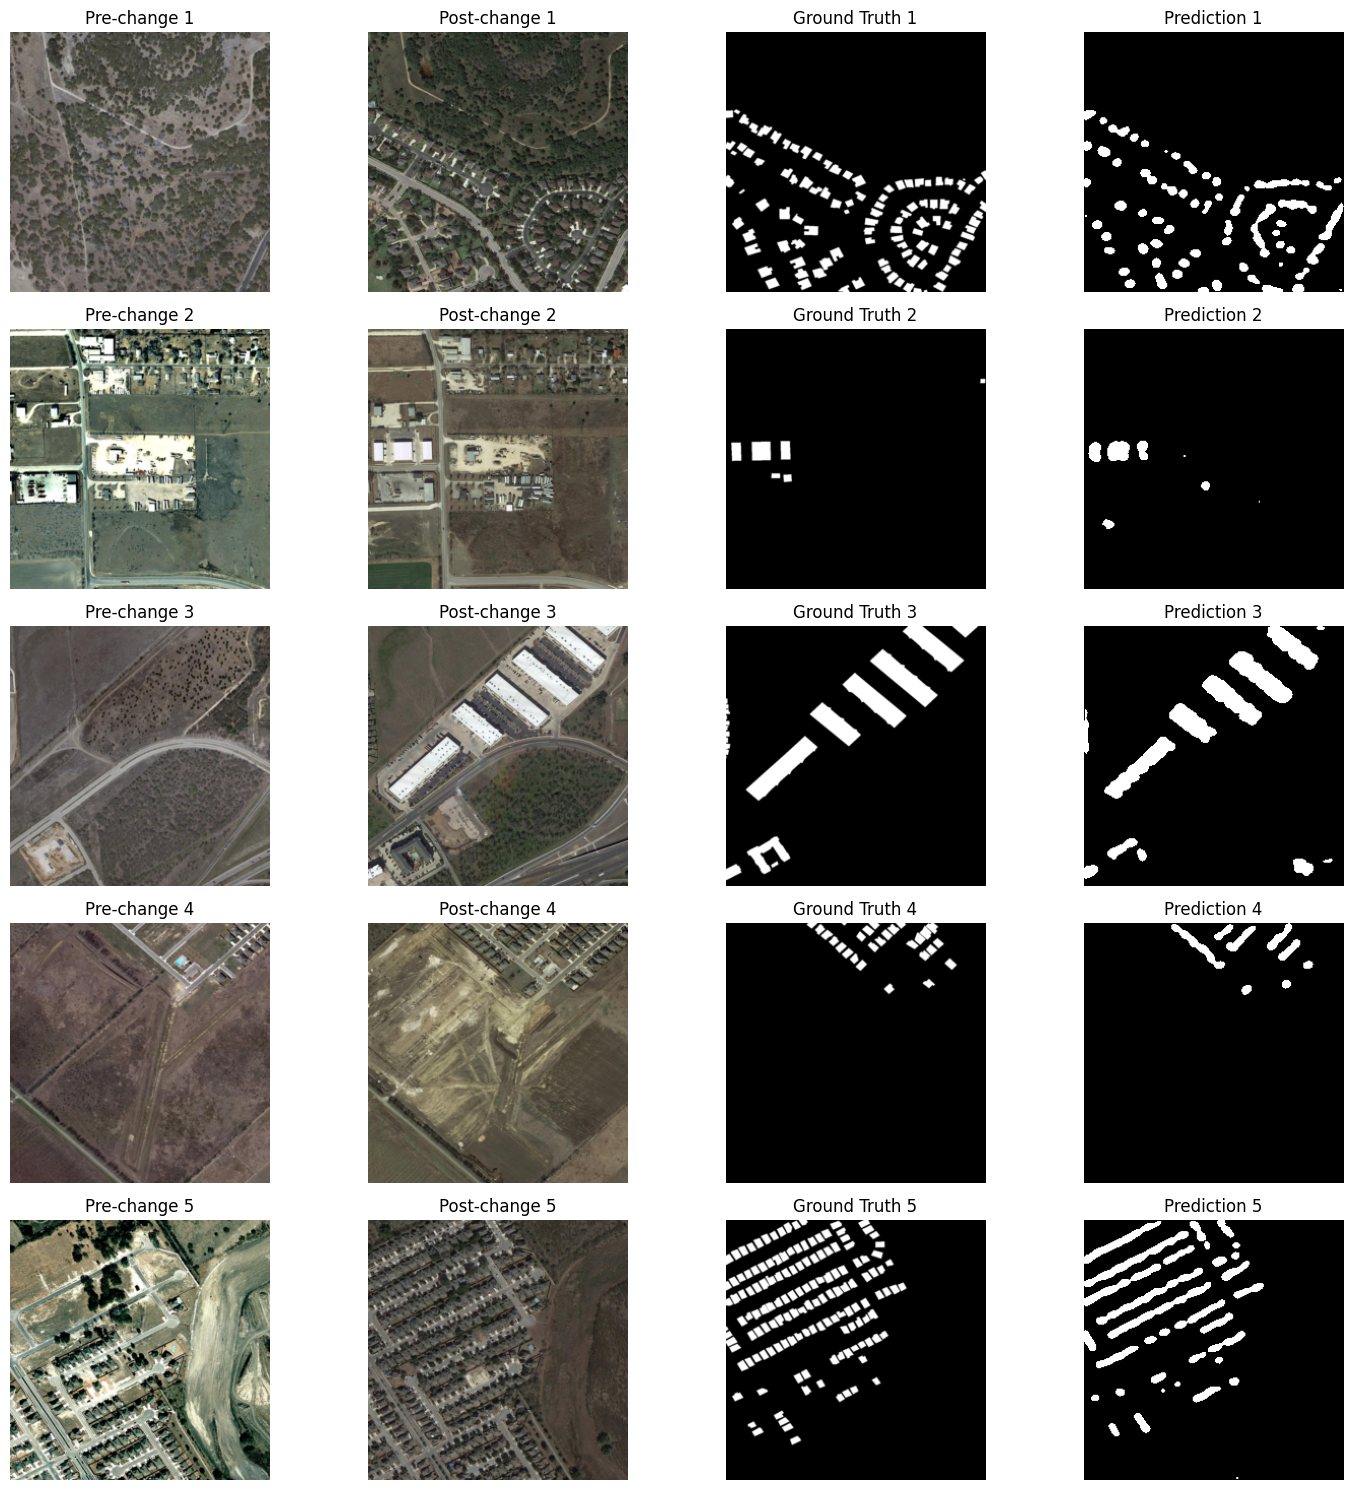

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random  # Make sure this is imported

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

plt.figure(figsize=(15, 15))

for i in range(5):
    # Get sample from dataset
    image1, image2, mask = test_dataset[i]

    # Add batch dimension and move to device
    image1 = image1.unsqueeze(0).to(device)
    image2 = image2.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)

    # Get prediction
    prediction = model(image1, image2)
    prediction = (prediction > 0.5).float()

    # Move tensors to CPU and remove batch dimension
    image1 = image1.squeeze().detach().cpu()
    image2 = image2.squeeze().detach().cpu()
    prediction = prediction.squeeze().detach().cpu()
    mask = mask.squeeze().detach().cpu()

    # Plot pre-change image
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(image1.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Pre-change {i+1}")

    # Plot post-change image
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(image2.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Post-change {i+1}")

    # Plot ground truth mask
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title(f"Ground Truth {i+1}")

    # Plot predicted mask
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(prediction, cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction {i+1}")

plt.tight_layout()
plt.savefig('Siamese_UNet_LEVIR_Results.png', bbox_inches='tight')
plt.show()

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehpatel3/test-aoi")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/test-aoi


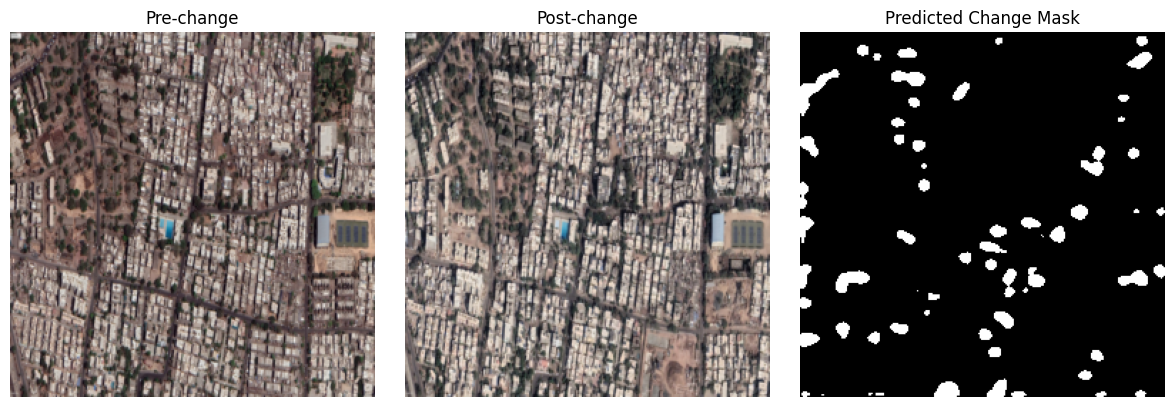

In [28]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Change to match your training size
    transforms.ToTensor(),
])

# Load your images from 'test-aoi'
img1 = Image.open('/kaggle/input/test-aoi/2019_max.jpg').convert('RGB')
img2 = Image.open('/kaggle/input/test-aoi/2022_max.jpg').convert('RGB')

# Apply transforms
input1 = transform(img1).unsqueeze(0).to(device)  # Shape: [1, 3, H, W]
input2 = transform(img2).unsqueeze(0).to(device)

# Put model in evaluation mode
model.eval()

# Get prediction
with torch.no_grad():
    output = model(input1, input2)
    prediction = (output > 0.5).float()

# Move tensors to CPU for display
input1 = input1.squeeze().cpu().permute(1, 2, 0)
input2 = input2.squeeze().cpu().permute(1, 2, 0)
prediction = prediction.squeeze().cpu()

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input1)
plt.title("Pre-change")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(input2)
plt.title("Post-change")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Predicted Change Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# Double Siamese

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Define the ConvBlock class
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Define the EncoderBlock class
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        p = self.maxpool(x)  # Save the output for skip connection
        return x, p  # Return both the output and the skip connection output

# Decoder block: Consist of upsample followed by two CNN
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Align the spatial dimensions of x and skip
        if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
            x = F.interpolate(x, size=(skip.size(2), skip.size(3)), mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# Double Decoder Siamese U-Net architecture
class DoubleDecoderSiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleDecoderSiameseUNet, self).__init__()

        # Encoder blocks for image 1 (pre-change)
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)

        # Encoder blocks for image 2 (post-change)
        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck - shared feature processing
        self.bottleneck = ConvBlock(1024, 1024)  # For concatenated features

        # Decoder blocks for image 1 (pre-change)
        self.decoder4a = DecoderBlock(1024, 512)
        self.decoder3a = DecoderBlock(512, 256)
        self.decoder2a = DecoderBlock(256, 128)
        self.decoder1a = DecoderBlock(128, 64)

        # Decoder blocks for image 2 (post-change)
        self.decoder4b = DecoderBlock(1024, 512)
        self.decoder3b = DecoderBlock(512, 256)
        self.decoder2b = DecoderBlock(256, 128)
        self.decoder1b = DecoderBlock(128, 64)

        # Final convolutional layers to output the masks
        self.final_conv_a = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_conv_b = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Final change detection layer - combines both decoder outputs
        self.change_conv = nn.Conv2d(64*2, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Encoder part for image 1 (pre-change)
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)

        # Encoder part for image 2 (post-change)
        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # Bottleneck - process combined features
        bottleneck = self.bottleneck(torch.cat([p4a, p4b], dim=1))

        # Decoder part for image 1 (pre-change)
        d4a = self.decoder4a(bottleneck, e4a)
        d3a = self.decoder3a(d4a, e3a)
        d2a = self.decoder2a(d3a, e2a)
        d1a = self.decoder1a(d2a, e1a)

        # Decoder part for image 2 (post-change)
        d4b = self.decoder4b(bottleneck, e4b)
        d3b = self.decoder3b(d4b, e3b)
        d2b = self.decoder2b(d3b, e2b)
        d1b = self.decoder1b(d2b, e1b)

        # Individual outputs - optional for auxiliary losses
        out_a = self.sigmoid(self.final_conv_a(d1a))
        out_b = self.sigmoid(self.final_conv_b(d1b))
        
        # Change detection output - combines features from both decoders
        change_features = torch.cat([d1a, d1b], dim=1)
        change_mask = self.sigmoid(self.change_conv(change_features))
        
        return change_mask, out_a, out_b

# Define the calculate_metrics function
def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculates various metrics for semantic segmentation.

    Args:
        predictions (torch.Tensor): Model predictions (logits or probabilities).
        targets (torch.Tensor): Ground truth masks (binary).
        threshold (float, optional): Threshold for converting probabilities to binary predictions.
                                     Defaults to 0.5.

    Returns:
        tuple: A tuple containing the calculated metrics (accuracy, precision, recall, Dice score, IoU).
    """
    # Threshold predictions to binary
    predictions = (predictions >= threshold).float()

    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)

    # True positives, false positives, true negatives, false negatives
    TP = (predictions * targets).sum()
    FP = (predictions * (1 - targets)).sum()
    TN = ((1 - predictions) * (1 - targets)).sum()
    FN = ((1 - predictions) * targets).sum()

    # Accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN + 1e-8)  # Add epsilon to avoid division by zero

    # Precision
    precision = TP / (TP + FP + 1e-8)

    # Recall
    recall = TP / (TP + FN + 1e-8)

    # Dice score
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    # Intersection over Union (IoU)
    iou = TP / (TP + FP + FN + 1e-8)

    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images_dir_b = os.path.join(data_dir, 'B')  # Prechange
        self.images_dir_a = os.path.join(data_dir, 'A')  # Postchange
        self.masks_dir = os.path.join(data_dir, 'label')
        
        self.transform = transform
        # Ensure consistent order of files
        self.images_b = sorted(f for f in os.listdir(self.images_dir_b) if f.endswith(('.jpg', '.png', '.jpeg')))
        self.images_a = sorted(f for f in os.listdir(self.images_dir_a) if f.endswith(('.jpg', '.png', '.jpeg')))
        self.masks = sorted(f for f in os.listdir(self.masks_dir) if f.endswith(('.jpg', '.png', '.jpeg')))

    def __len__(self):
        return len(self.images_b)

    def __getitem__(self, idx):
        img_path_b = os.path.join(self.images_dir_b, self.images_b[idx])
        img_path_a = os.path.join(self.images_dir_a, self.images_a[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        
        # Load images
        image_b = cv2.imread(img_path_b, cv2.IMREAD_COLOR)  # BGR
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_b = image_b.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        image_a = cv2.imread(img_path_a, cv2.IMREAD_COLOR)  # BGR
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_a = image_a.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        # Apply transformations consistently
        if self.transform:
            transformed = self.transform(image=image_b, image_a=image_a, mask=mask)
            image_b = transformed['image']  # Pre-change
            image_a = transformed['image_a']  # Post-change
            mask = transformed['mask']  # Mask
        
        # Convert mask to tensor and add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        
        return image_b, image_a, mask

# Custom loss function combining BCE loss and Dice loss for segmentation
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCELoss(weight=weight, size_average=size_average)
        
    def forward(self, inputs, targets):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)
        
        # Dice Loss
        smooth = 1.0
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        # Combined loss (you can adjust the weighting)
        return 0.5 * bce_loss + 0.5 * dice_loss

# Main training function
def train_double_decoder_siamese_unet(data_dir, num_epochs=20, batch_size=16, learning_rate=1e-4):
    # Albumentations transformations
    train_transform = A.Compose([
        A.Resize(height=256, width=256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        ToTensorV2(),
    ], additional_targets={'image_a': 'image'})

    val_transform = A.Compose([
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ], additional_targets={'image_a': 'image'})

    # Dataset
    train_dataset = CustomDataset(data_dir=os.path.join(data_dir, 'train'), transform=train_transform)
    val_dataset = CustomDataset(data_dir=os.path.join(data_dir, 'val'), transform=val_transform)
    test_dataset = CustomDataset(data_dir=os.path.join(data_dir, 'test'), transform=val_transform)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = DoubleDecoderSiameseUNet(in_channels=3, out_channels=1)
    
    # Move model to device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Loss function and optimizer
    criterion = BCEDiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
    
    # Training loop
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for x1, x2, mask in train_loader:
            # Move data to device
            x1, x2, mask = x1.to(device), x2.to(device), mask.to(device)
            
            # Forward pass
            change_mask, mask_a, mask_b = model(x1, x2)
            
            # Calculate loss - main loss on change mask, auxiliary losses on individual outputs
            loss = criterion(change_mask, mask)
            
            # Optional: Add auxiliary losses from individual decoder outputs if needed
            # loss_a = criterion(mask_a, mask) * 0.2  # Weighted auxiliary loss
            # loss_b = criterion(mask_b, mask) * 0.2  # Weighted auxiliary loss
            # total_loss = loss + loss_a + loss_b
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Calculate average training loss
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics = [0.0, 0.0, 0.0, 0.0, 0.0]  # acc, prec, recall, dice, iou
        
        with torch.no_grad():
            for x1, x2, mask in val_loader:
                # Move data to device
                x1, x2, mask = x1.to(device), x2.to(device), mask.to(device)
                
                # Forward pass
                change_mask, _, _ = model(x1, x2)
                
                # Calculate loss
                loss = criterion(change_mask, mask)
                val_loss += loss.item()
                
                # Calculate metrics
                batch_metrics = calculate_metrics(change_mask, mask)
                for i in range(5):
                    val_metrics[i] += batch_metrics[i]
        
        # Calculate average validation loss and metrics
        val_loss /= len(val_loader)
        val_metrics = [metric / len(val_loader) for metric in val_metrics]
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Metrics - Acc: {val_metrics[0]:.4f}, Prec: {val_metrics[1]:.4f}, " 
              f"Recall: {val_metrics[2]:.4f}, Dice: {val_metrics[3]:.4f}, IoU: {val_metrics[4]:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_double_decoder_siamese_unet.pth')
            print("  Saved best model!")
        
        print()
    
    # Load best model for testing
    model.load_state_dict(torch.load('best_double_decoder_siamese_unet.pth'))
    
    # Testing phase
    model.eval()
    test_metrics = [0.0, 0.0, 0.0, 0.0, 0.0]  # acc, prec, recall, dice, iou
    
    with torch.no_grad():
        for x1, x2, mask in test_loader:
            # Move data to device
            x1, x2, mask = x1.to(device), x2.to(device), mask.to(device)
            
            # Forward pass
            change_mask, _, _ = model(x1, x2)
            
            # Calculate metrics
            batch_metrics = calculate_metrics(change_mask, mask)
            for i in range(5):
                test_metrics[i] += batch_metrics[i]
    
    # Calculate average test metrics
    test_metrics = [metric / len(test_loader) for metric in test_metrics]
    
    print("Test Results:")
    print(f"  Accuracy: {test_metrics[0]:.4f}")
    print(f"  Precision: {test_metrics[1]:.4f}")
    print(f"  Recall: {test_metrics[2]:.4f}")
    print(f"  Dice Score: {test_metrics[3]:.4f}")
    print(f"  IoU: {test_metrics[4]:.4f}")
    
    return model

# Use the function
if __name__ == "__main__":
    # Example usage
    model = train_double_decoder_siamese_unet(
        data_dir='/kaggle/input/levid-custom/levid_custom',
        num_epochs=20,
        batch_size=16,
        learning_rate=1e-4
    )